In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# builtins
import locale
import math
import glob
import pathlib
import functools
import logging

# numerical stuff
#import pickle5 as pickle
import tables


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Conv2DTranspose, Reshape
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, Input, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
#from tensorflow.python import ipu

# plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from mpl_toolkits.axes_grid1 import make_axes_locatable

logging.basicConfig(level=logging.INFO)

In [ ]:
data_path_train = 'gs://bathy_sample/processed/20211013/train_data_mask_no_schematic'
data_path_test = 'gs://bathy_sample/processed/20211013/test_data_mask_no_schematic'
meta_data_path = '/mnt/poddata/data/bathy-emodnet-a-runs.h5'
all_checkpoints_path = 'gs://bathy_sample/dnn/checkpoints'
all_checkpoints_path = '/content/drive/MyDrive/DeepLearning/Benchmark/checkpoints'
model_name = 'guus-2d-mlp-cnn-v1.2'
model_path = '/content/drive/MyDrive/DeepLearning/Benchmark/mask_models'
learning_rate = 1e-4
n_epochs = 100
batch_size = 1
raster_shape = (256, 256, 1)
checkpoints_path = all_checkpoints_path + '/' + model_name
#Get mean and std from before standardization
input_attributes = np.load('/content/drive/MyDrive/DeepLearning/input_attributes.npy', allow_pickle=True).item()
(eta_mean, eta_std) = input_attributes['eta'].values()
(zeta_mean, zeta_std) = input_attributes['zeta'].values()
(bathy_mean, bathy_std) = input_attributes['bathy'].values()

In [ ]:
def tf_parse(eg):
    """parse an example (or batch of examples, not quite sure...)"""

    # here we re-specify our format
    # you can also infer the format from the data using tf.train.Example.FromString
    # but that did not work
    example = tf.io.parse_example(
        eg[tf.newaxis],
        {
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'depth': tf.io.FixedLenFeature([], tf.int64),
            'bathy': tf.io.FixedLenFeature([], tf.string),
            'hs': tf.io.FixedLenFeature([], tf.string),
            'tm01': tf.io.FixedLenFeature([], tf.string),
            'theta0x': tf.io.FixedLenFeature([], tf.string),
            'theta0y': tf.io.FixedLenFeature([], tf.string),
            'eta': tf.io.FixedLenFeature([], tf.float32),
            'zeta': tf.io.FixedLenFeature([], tf.float32),
            'theta_wavex': tf.io.FixedLenFeature([], tf.float32),
            'theta_wavey': tf.io.FixedLenFeature([], tf.float32),
            'mask': tf.io.FixedLenFeature([], tf.string),
        },
    )
    bathy = tf.io.parse_tensor(example["bathy"][0], out_type="float32")
    bathy = tf.ensure_shape(bathy, raster_shape)    # ensure shape, to be able to train the model
    hs = tf.io.parse_tensor(example["hs"][0], out_type="float32")
    hs = tf.ensure_shape(hs, raster_shape)
    tm01 = tf.io.parse_tensor(example["tm01"][0], out_type="float32")
    tm01 = tf.ensure_shape(tm01, raster_shape)
    theta0x = tf.io.parse_tensor(example["theta0x"][0], out_type="float32")
    theta0x = tf.ensure_shape(theta0x, raster_shape)
    theta0y = tf.io.parse_tensor(example["theta0y"][0], out_type="float32")
    theta0y = tf.ensure_shape(theta0y, raster_shape)
    eta = example["eta"]
    zeta = example["zeta"]
    theta_wavex = example["theta_wavex"]
    theta_wavey = example["theta_wavey"]
    # Angles were in degrees instead of radians when dataset created, so adjust theta_wavex and theta_wavey
    theta_wave = (tf.math.atan2(theta_wavey, theta_wavex) + 2*np.pi) % (2*np.pi) * np.pi / 180.
    theta_wavex = tf.math.cos(theta_wave)
    theta_wavey = tf.math.sin(theta_wave)
    # Output mask
    mask = tf.io.parse_tensor(example["mask"][0], out_type="bool")
    mask = tf.cast(mask, dtype="int16")
    mask = tf.ensure_shape(mask, raster_shape)
    # Create mask for input where waterlevel is less than bathymetry
    # Bathymetry is constructed back from standardization
    bathy_mask = tf.math.greater(bathy * bathy_std + bathy_mean, eta * eta_std + eta_mean)
    bathy_mask = tf.cast(bathy_mask, dtype="float32")
    img_input = tf.concat([bathy,bathy_mask],-1)
    attr = tf.stack([eta, zeta, theta_wavex, theta_wavey], axis=1)
    attr = tf.reshape(attr,shape=[-1])
    output = (hs, tm01, theta0x, theta0y)
    output = tf.concat([hs, tm01, theta0x, theta0y, bathy_mask], axis=-1)
    #output = hs
    return (img_input, attr), (output, mask)

In [ ]:
def get_files(data_path):
    files = tf.io.gfile.glob(data_path + "/" + "*.tfrecords")
    return files

def get_dataset(files):
    """return a tfrecord dataset with all tfrecord files"""
    dataset =  tf.data.TFRecordDataset(files)
    dataset = dataset.map(tf_parse)
    return dataset

In [ ]:
def create_mlp(dim):
    input = Input(shape=dim)
    x = Dense(256, activation='relu')(input)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(4, activation='relu')(x)
    x = Dense(1, activation='relu')(x)

    model = Model(input, x)
        
    return model

def create_cnn(width, height, depth):
    input_shape = (height, width, depth)
    
    inputs = Input(shape=input_shape)
    x = Conv2D(16, (3,3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    ax = MaxPooling2D(pool_size=(2,2))(x)

    #Branch 1
    x = Conv2D(32, (3,3), padding="same")(ax)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    bx = MaxPooling2D(pool_size=(2,2))(x)

    #Branch 2
    x = Conv2D(64, (3,3), padding="same")(bx)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    cx = MaxPooling2D(pool_size=(2,2))(x)

    #Branch 3
    x = Conv2D(128, (3,3), padding="same")(cx)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(256, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=(2,2))(x)
    x = Conv2DTranspose(256, (3,3), padding="same")(x)

    #Branch 2
    x = Concatenate()([x, cx])
    x = Conv2D(128, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2DTranspose(64, (3,3), padding="same")(x)

    #Branch 1
    x = Concatenate()([x, bx])
    x = Conv2D(32, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2DTranspose(16, (3,3), padding="same")(x)

    #Main Branch
    x = Concatenate()([x,ax])
    x = Conv2D(16, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(4, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(1, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    model = Model(inputs, x)
    
    return model
    
def full_model(cnn_input_shape, mlp_input_shape):
    
    mlp_input = Input(mlp_input_shape)
    with ipu.keras.PipelineStage(0):
        x = Dense(256, activation='relu')(mlp_input)
        x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        x = Dense(32, activation='relu')(x)
        x = Dense(16, activation='relu')(x)
        mlp_output = Dense(4, activation='relu')(x)
    
    cnn_input = Input(cnn_input_shape)
    
    with ipu.keras.PipelineStage(1):
        x = Conv2D(16, (3,3), padding="same")(cnn_input)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        ax = MaxPooling2D(pool_size=(2,2))(x)

        #Branch 1
        x = Conv2D(32, (3,3), padding="same")(ax)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        bx = MaxPooling2D(pool_size=(2,2))(x)

        #Branch 2
        x = Conv2D(64, (3,3), padding="same")(bx)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        cx = MaxPooling2D(pool_size=(2,2))(x)

        #Branch 3
        x = Conv2D(128, (3,3), padding="same")(cx)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2,2))(x)
        x = Conv2D(256, (3,3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)

        x = UpSampling2D(size=(2,2))(x)
        x = Conv2DTranspose(256, (3,3), padding="same")(x)

        #Branch 2
        x = Concatenate()([x, cx])
        x = Conv2D(128, (3,3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = UpSampling2D(size=(2,2))(x)
        x = Conv2DTranspose(64, (3,3), padding="same")(x)

        #Branch 1
        x = Concatenate()([x, bx])
        x = Conv2D(32, (3,3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = UpSampling2D(size=(2,2))(x)
        x = Conv2DTranspose(16, (3,3), padding="same")(x)

        #Main Branch
        x = Concatenate()([x,ax])
        x = Conv2D(16, (3,3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(pool_size=(2,2))(x)
        x = Conv2D(4, (3,3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(pool_size=(2,2))(x)
        x = Conv2D(1, (3,3), padding="same")(x)
        x = Activation("relu")(x)
        cnn_output = BatchNormalization()(x)
    
    with ipu.keras.PipelineStage(2):
        conv_shape = K.int_shape(cnn_output)

        x = Flatten()(cnn_output)
        x = Dense(64, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(16, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(4, activation="relu")(x)
        x = BatchNormalization()(x)

        x = Concatenate()([x,mlp_output])
        x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation="relu")(x)
        x = BatchNormalization()(x)

        x = Reshape((conv_shape[1],conv_shape[2],int(conv_shape[3])))(x)
    
    with ipu.keras.PipelineStage(3):
        x = Conv2D(16, (3,3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)

        x = Conv2D(64, (3,3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)

        x = Conv2D(128, (3,3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)

        x = Conv2D(256, (3,3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)

        x = UpSampling2D(size=(2,2))(x)
        x = Conv2DTranspose(256, (3,3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)

        x = UpSampling2D(size=(2,2))(x)
        x = Conv2DTranspose(64, (3,3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)

        x = UpSampling2D(size=(2,2))(x)
        x = Conv2DTranspose(1, (3,3), padding="same", activation="linear")(x)

    model = Model(inputs=[cnn_input, mlp_input], outputs = x)
    
    return model



In [ ]:
train_files = get_files(data_path_train)
test_files = get_files(data_path_test)

train_dataset = get_dataset(train_files)
test_dataset = get_dataset(test_files)

#Filter out the bathymetries with heights greater than 100m
def filter_fn(x, y):
    return tf.less_equal(tf.reduce_max(x[0][...,0]), (100-bathy_mean)/bathy_std)

train_dataset = train_dataset.filter(filter_fn)
test_dataset = test_dataset.filter(filter_fn)

train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

In [ ]:
def masked_mse_loss(y_true, y_pred):
    # Get input mask from the output data
    mask = y_true[...,-1]
    mask = mask[...,tf.newaxis]
    # Get the true output data which we want to train
    y_true = y_true[...,:-1]
    y_pred_temp = tf.math.multiply(y_pred, 1 - mask)
    y_true_temp = tf.math.multiply(y_true, 1 - mask)
    diff = tf.math.squared_difference(y_true_temp, y_pred_temp)
    loss = K.mean(diff, axis=-1)
    return diff, y_true_temp

In [ ]:
for sample in train_dataset.take(1):
    #print(repr(sample))
    print(sample[1][0][...,:-1].numpy())
    print(1 - sample[1][0][...,-1])
    mask = 1 - sample[1][0][...,-1]
    print(tf.math.multiply(sample[1][0][...,:-1], mask[...,tf.newaxis]))

In [ ]:
for sample in train_dataset.take(1):
    print(repr(sample))
b = np.stack(([[1,1],[2,2]],[[0,0],[1,1]]), axis=-1)
c = np.stack(([[3,4],[5,6]],[[0,0],[1,1]]), axis=-1)
y_true = np.array([b,b])
y_pred = np.array([[[3,4],[5,6]],[[1,1],[2,2]]])

print(y_true[...,-1], y_pred)
masked_mse_loss(y_true, y_pred)

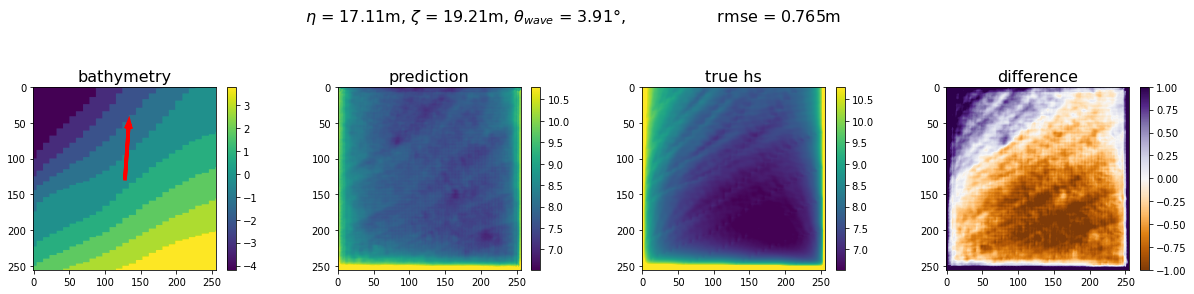

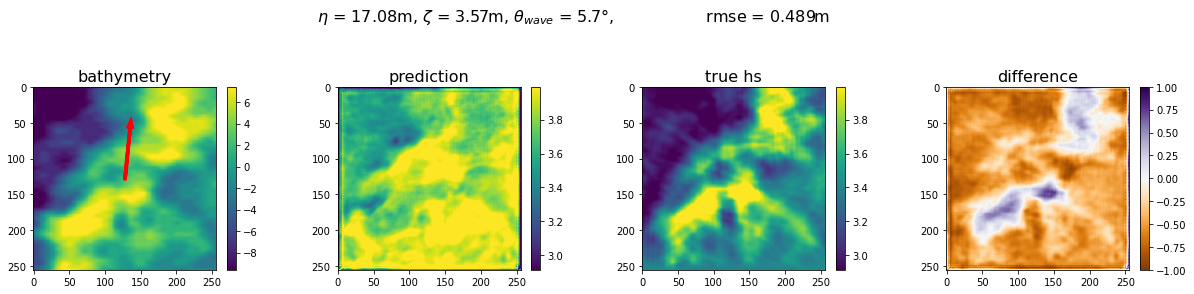

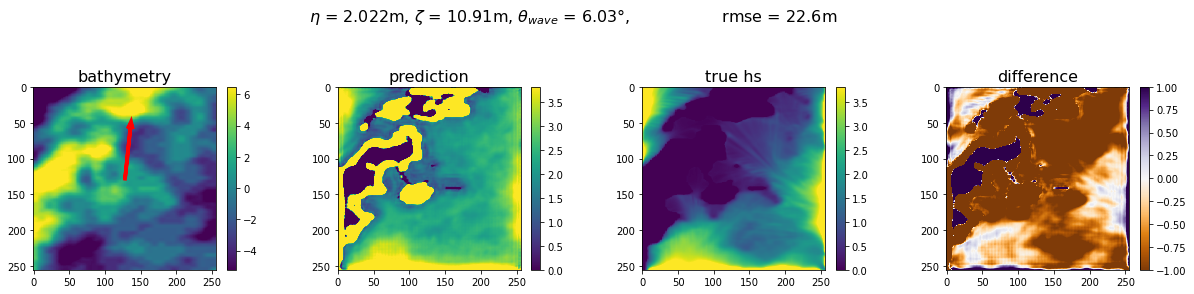

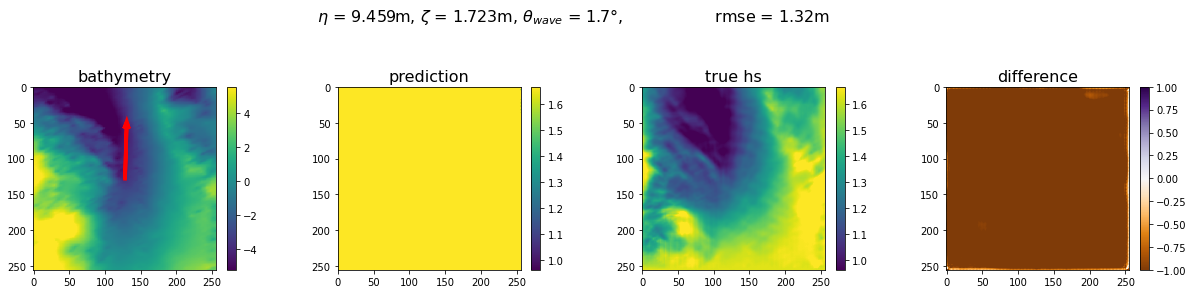

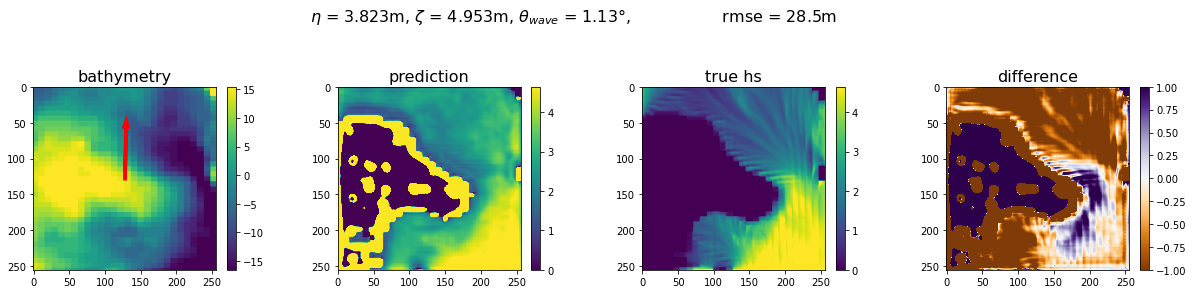

In [ ]:
model = load_model(model_path + '/' + model_name + '.h5', compile=False)
# Get the mean and std of the input before standardization
(eta_mean, eta_std) = input_attributes['eta'].values()
(zeta_mean, zeta_std) = input_attributes['zeta'].values()
(bathy_mean, bathy_std) = input_attributes['bathy'].values()
#theta_wave = {np.arctan2(theta_wavey, theta_wavex):.3},

ls = LightSource(azdeg=315, altdeg=45)
#im = axes[0].imshow(ls.hillshade(bathy.numpy()))

skip_count = 2
index = 0
for sample in test_dataset.skip(skip_count*5).take(5):
    # sample is a tuple of (input, output)
    (input, output) = sample
    #bathy = input[0][index,...,1]
    bathy = input[0][0,...,0]*bathy_std + bathy_mean # take bathymetry from input tuple
    (eta, zeta, theta_wavex, theta_wavey) = input[1][0,:] # take attributes from input tuple
    prediction = model.predict(input)[index][0,:,:,0] # take first element of the batch and take the first and only channel
    #prediction = output[index][:,:,0]
    true_hs = output[index][0,...,0]
    (vmin, vmax) = np.percentile(true_hs, [5, 95])
    (vmin2, vmax2) = np.percentile(bathy, [5, 95])
    (vmin3, vmax3) = np.percentile(prediction, [5, 95])
    
    fig, axes = plt.subplots(figsize=(20,5), ncols=4)
    plt.subplots_adjust(wspace=0.5)
    fig.suptitle(f'$\eta$ = {eta*eta_std + eta_mean:.4}m, $\zeta$ = {zeta*zeta_std + zeta_mean:.4}m, $\\theta_{{wave}}$ = {np.arctan2(theta_wavey, theta_wavex) * 180/np.pi:.3}$\degree$, \
                 rmse = {np.sqrt(tf.reduce_mean((true_hs - prediction)**2)):.3}m',
                 fontsize=16)

    axes[0].set_title('bathymetry', fontsize=16)
    im = axes[0].imshow(bathy, vmin=vmin2, vmax=vmax2)
    axes[0].arrow(128,128, 70*theta_wavey, -70*theta_wavex, color='red', lw=3.7, overhang=0.80, head_width=6.8)
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes("right", size="5%", pad=0.15)
    plt.colorbar(im, cax=cax)
    #plt.colorbar(im, orientation='vertical', ax=axes[0])
    
    axes[1].set_title('prediction', fontsize=16)
    im = axes[1].imshow(prediction, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes("right", size="5%", pad=0.15)
    plt.colorbar(im, cax=cax)
    #plt.colorbar(im, orientation='vertical', ax=axes[1])
    
    axes[2].set_title('true hs', fontsize=16)
    im = axes[2].imshow(true_hs, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[2])
    cax = divider.append_axes("right", size="5%", pad=0.15)
    plt.colorbar(im, cax=cax)
    #plt.colorbar(im, orientation='vertical', ax=axes[2])
    
    axes[3].set_title('difference', fontsize=16)
    im = axes[3].imshow(true_hs - prediction, cmap='PuOr', vmin=-1, vmax=1)
    divider = make_axes_locatable(axes[3])
    cax = divider.append_axes("right", size="5%", pad=0.15)
    plt.colorbar(im, cax=cax)
    #plt.colorbar(im, orientation='vertical', ax=axes[3])
    
    
    plt.show()
    #print(sample[0])


Text(0, 0.5, 'MSE loss')

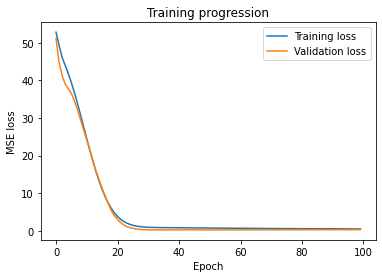

In [ ]:
history = pd.read_csv(all_checkpoints_path + '/' + model_name + '.csv')

plt.title('Training progression')
plt.plot(history['loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE loss')

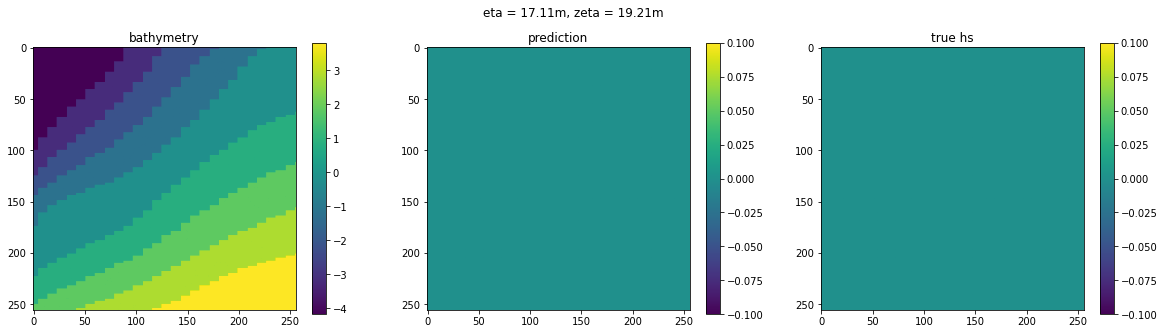

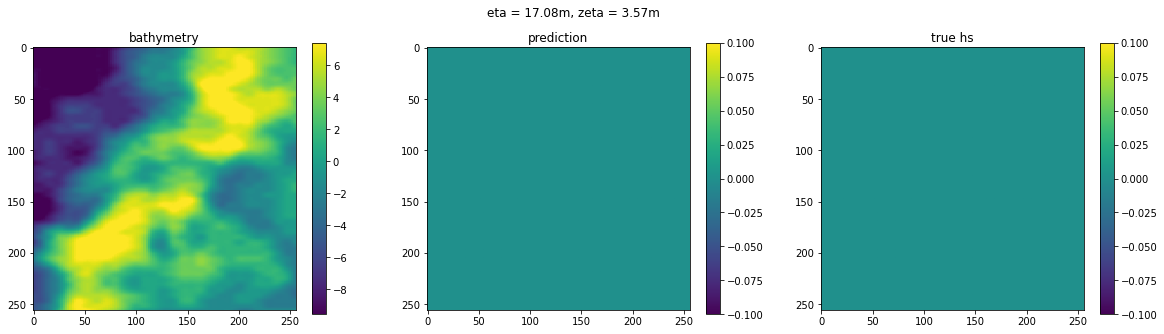

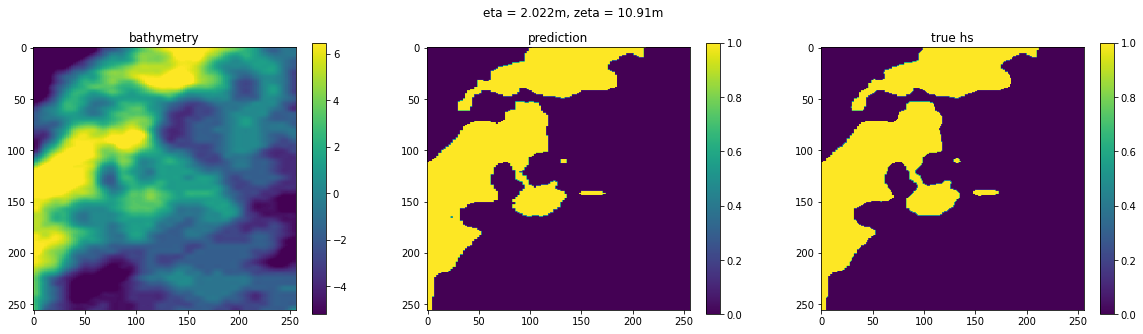

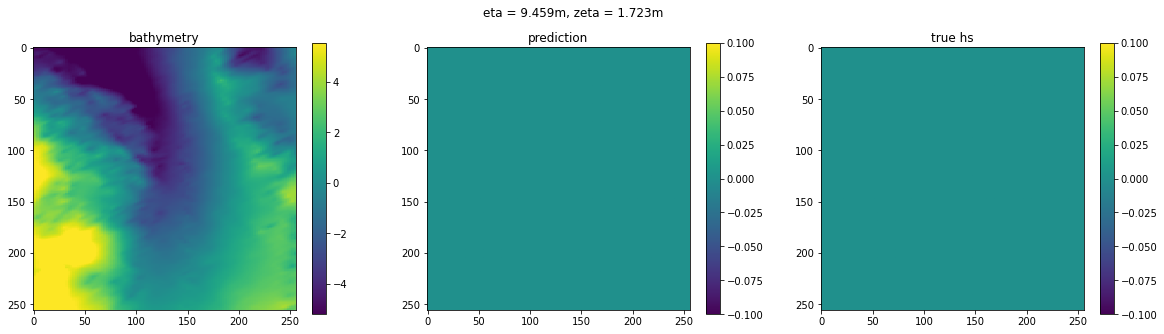

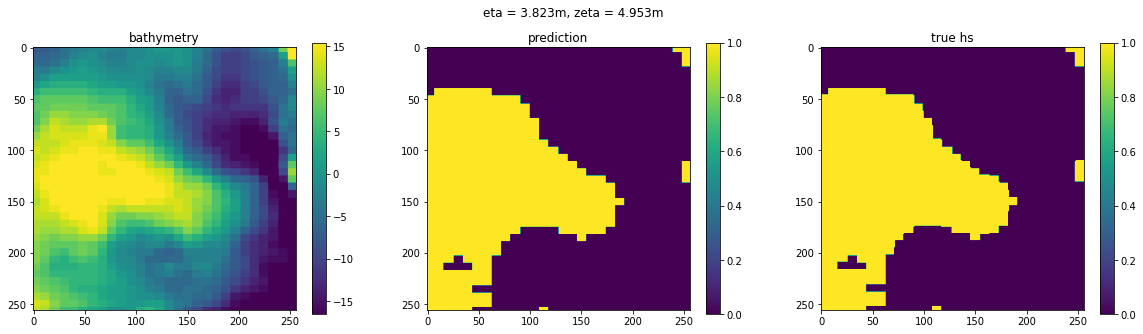

In [ ]:
model = load_model(model_path + '/' + model_name + '.h5')
# Get the mean and std of the input before standardization

ls = LightSource(azdeg=315, altdeg=45)
#im = axes[0].imshow(ls.hillshade(bathy.numpy()))

skip_count = 2
index = 1
for sample in test_dataset.skip(skip_count*5).take(5):
    # sample is a tuple of (input, output)
    (input, output) = sample
    #bathy = input[0][index,...,1]
    bathy = input[0][0,...,0]*bathy_std + bathy_mean # take bathymetry from input tuple
    (eta, zeta, theta_wavex, theta_wavey) = input[1][0,:] # take attributes from input tuple
    prediction = model.predict(input)[index][0,:,:,0] # take first element of the batch and take the first and only channel
    idx = prediction > 0.05
    idx2 = prediction <= 0.05
    prediction[idx] = 1
    prediction[idx2] = 0 
    prediction = output[index][:,:,0]
    true_hs = output[index][0,:,:,0]

    (vmin, vmax) = np.percentile(true_hs, [5, 95])
    (vmin2, vmax2) = np.percentile(bathy, [5, 95])
    (vmin3, vmax3) = np.percentile(prediction, [5, 95])
    
    fig, axes = plt.subplots(figsize=(20,5), ncols=3)
    fig.suptitle(f'eta = {eta*eta_std + eta_mean:.4}m, zeta = {zeta*zeta_std + zeta_mean:.4}m')

    axes[0].set_title('bathymetry')
    im = axes[0].imshow(bathy, vmin=vmin2, vmax=vmax2)
    plt.colorbar(im, orientation='vertical', ax=axes[0])
    
    axes[1].set_title('prediction')
    im = axes[1].imshow(prediction, vmin=vmin3, vmax=vmax3)
    plt.colorbar(im, orientation='vertical', ax=axes[1])
    
    axes[2].set_title('true hs')
    im = axes[2].imshow(true_hs, vmin=vmin, vmax=vmax)
    plt.colorbar(im, orientation='vertical', ax=axes[2])
    
    plt.show()
    #print(sample[0])
